In [1]:
import os
import requests
import pandas as pd
import geopandas as gpd
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from tqdm.auto import tqdm

In [2]:
from minio import Minio
from minio.error import S3Error

In [3]:
## Constantes

minio_endpoint = 'minio:9000'
minio_user = os.environ['MINIO_ROOT_USER']
minio_password = os.environ['MINIO_ROOT_PASSWORD']
buckets = ['bronze', 'silver', 'gold']

ibge_url = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2024/Brasil/BR_Municipios_2024.zip'
nasa_api_base_url = 'https://power.larc.nasa.gov'
municipalities_variables = ['CD_MUN', 'NM_MUN', 'NM_UF', 'SIGLA_UF', 'NM_REGIA', 'AREA_KM2', 'LATITUDE', 'LONGITUDE']

jars = ['./aws-java-sdk-bundle-1.12.262.jar', './hadoop-aws-3.3.4.jar']

In [7]:
## Verificando a existencia dos buckets no MinIO

minio_client = Minio(
    minio_endpoint,
    access_key=minio_user,
    secret_key=minio_password,
    secure=False,
)

for bucket in buckets:
    if not minio_client.bucket_exists(bucket):
        minio_client.make_bucket(bucket)
        print(f'Make bucket {bucket}!')
    else:
        print(f'Bucket {bucket} already exists!')

Make bucket bronze!
Make bucket silver!
Make bucket gold!


In [8]:
## Sessao spark

spark = (
    SparkSession
        .builder
        .master("spark://spark:7077")
        .appName('MinIO - Teste')
        .config('spark.hadoop.fs.s3a.endpoint', minio_endpoint)
        .config('spark.hadoop.fs.s3a.access.key', minio_user)
        .config('spark.hadoop.fs.s3a.secret.key', minio_password)
        .config('spark.hadoop.fs.s3a.path.style.access', 'true')
        .config('spark.hadoop.fs.s3a.connection.ssl.enabled', 'false')
        .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
        # .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk-bundle:1.12.262,org.apache.hadoop:hadoop-aws:3.3.4')
        .config('spark.jars', ', '.join(jars))
        .getOrCreate()
)

25/05/14 00:29:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Passo 1: 
## Baixar os dados do ibge sobre os municipios brasileiros
### Camada silver

In [9]:
# Pegando todos os municipios brasileiros
municipalities_br_gdf = gpd.read_file(ibge_url)
municipalities_br_gdf.head(2)

,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry
0,2504108,Carrapateira,250015,Cajazeiras,2504,Sousa - Cajazeiras,25,Paraíba,PB,2,Nordeste,NE,None,None,59.070,"POLYGON ((-38.33672 -6.99279, -38.33653 -6.993..."
1,1718451,Pugmil,170003,Paraíso do Tocantins,1701,Palmas,17,Tocantins,TO,1,Norte,N,None,None,401.174,"POLYGON ((-48.91085 -10.53824, -48.911 -10.538..."


In [10]:
municipalities_br_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CD_MUN    5573 non-null   object  
 1   NM_MUN    5573 non-null   object  
 2   CD_RGI    5571 non-null   object  
 3   NM_RGI    5571 non-null   object  
 4   CD_RGINT  5571 non-null   object  
 5   NM_RGINT  5571 non-null   object  
 6   CD_UF     5573 non-null   object  
 7   NM_UF     5573 non-null   object  
 8   SIGLA_UF  5573 non-null   object  
 9   CD_REGIA  5573 non-null   object  
 10  NM_REGIA  5573 non-null   object  
 11  SIGLA_RG  5573 non-null   object  
 12  CD_CONCU  660 non-null    object  
 13  NM_CONCU  660 non-null    object  
 14  AREA_KM2  5573 non-null   float64 
 15  geometry  5573 non-null   geometry
dtypes: float64(1), geometry(1), object(14)
memory usage: 696.8+ KB


<Axes: >

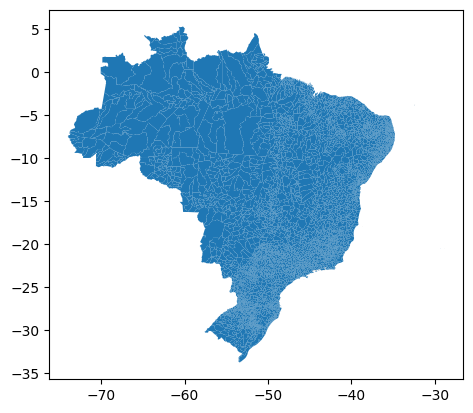

In [11]:
municipalities_br_gdf.plot()

<Axes: >

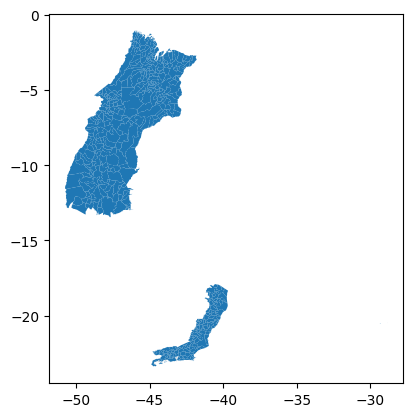

In [13]:
# limitando pelos estados do ES e RJ
municipalities_br_gdf = municipalities_br_gdf.query(
    'SIGLA_UF in ["ES", "RJ", "MA", "TO"]'
)

municipalities_br_gdf.plot()

In [14]:
# determinando as coordenadas centrais de cada municipio
municipalities_br_gdf['localizacao'] = municipalities_br_gdf.geometry.centroid
municipalities_br_gdf['LATITUDE'] = municipalities_br_gdf.localizacao.y
municipalities_br_gdf['LONGITUDE'] = municipalities_br_gdf.localizacao.x

# pegando apenas variaveis de interesse
municipalities_br_gdf = municipalities_br_gdf[municipalities_variables]

# construindo o dataframe spark
municipalities_br_df = spark.createDataFrame(municipalities_br_gdf)
municipalities_br_df.show(2)

/tmp/ipykernel_21/1018514499.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipalities_br_gdf['localizacao'] = municipalities_br_gdf.geometry.centroid
                                                                                

+-------+-------+---------+--------+--------+--------+-------------------+------------------+
| CD_MUN| NM_MUN|    NM_UF|SIGLA_UF|NM_REGIA|AREA_KM2|           LATITUDE|         LONGITUDE|
+-------+-------+---------+--------+--------+--------+-------------------+------------------+
|1718451| Pugmil|Tocantins|      TO|   Norte| 401.174|-10.422515266069075|-48.88235878582917|
|2104206|Fortuna| Maranhão|      MA|Nordeste| 835.668| -5.634388261773991|-44.01463010094357|
+-------+-------+---------+--------+--------+--------+-------------------+------------------+
only showing top 2 rows



In [15]:
# salvando os dados na camada bronze
(
    municipalities_br_df
        .write
        .partitionBy(['NM_REGIA', 'SIGLA_UF'])
        .mode('overwrite')
        .parquet('s3a://bronze/municipalities.parquet')
)

25/05/14 00:38:44 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
                                                                                

# Passo 2: 
## Dados climaticos por municipios
### Camada Silver

### Variáveis climaticas: https://power.larc.nasa.gov/
- 🌡️ Temperatura:
    - T2M: Temperatura média do ar a 2 metros (°C)
    - T2M_MAX: Temperatura máxima diária a 2 metros (°C)
    - T2M_MIN: Temperatura mínima diária a 2 metros (°C)
    - TS: Temperatura da superfície terrestre (°C)
- 🌧️ Precipitação e Umidade
    - PRECTOT: Precipitação total diária (mm)
    - RH2M: Umidade relativa a 2 metros (%)

In [20]:
# constantes para o consumo da API
api_url = f'{nasa_api_base_url}/api/temporal/daily/point'
community = 'sb'  # Agricultura (ag) ou Energia (sb)
climatology_variables = ['T2M', 'T2M_MAX', 'T2M_MIN', 'TS', 'PRECTOT', 'RH2M']
years = [2023, 2024]

In [21]:
municipalities_br_gdf.head(2)

,CD_MUN,NM_MUN,NM_UF,SIGLA_UF,NM_REGIA,AREA_KM2,LATITUDE,LONGITUDE
1,1718451,Pugmil,Tocantins,TO,Norte,401.174,-10.422515,-48.882359
2,2104206,Fortuna,Maranhão,MA,Nordeste,835.668,-5.634388,-44.014630


In [22]:
len(municipalities_br_gdf['SIGLA_UF'].unique())

4

In [23]:
climatology_municipalities_br_data = []
for year in tqdm(years, desc='download dos dados por ano'):
    for state in municipalities_br_gdf['SIGLA_UF'].unique():
        
        state_gdf = municipalities_br_gdf.query("SIGLA_UF == @state")
        count = 0
        
        with tqdm(total=state_gdf.shape[0], desc='download dos dados por municipio') as pbar:
            for mun in state_gdf.itertuples():
                url = (
                    f'{api_url}?start={year}0101&end={year}1231'
                    f'&latitude={mun.LATITUDE}&longitude={mun.LONGITUDE}'
                    f'&community={community}'
                    f'&parameters={','.join(climatology_variables)}'
                    '&format=json'
                )
                
                # Requisição
                response = requests.get(url)
                if response.status_code == 200:
                    data = response.json()
                    records = data['properties']['parameter']
                
                    # Montar DataFrame
                    df = pd.DataFrame(records)
                    df.reset_index(inplace=True)
                    df['index'] = pd.to_datetime(df['index'], format='%Y%m%d').dt.date
                    df.rename({'index':'DATE'}, axis=1, inplace=True)
                    df['NM_REGIA'] = mun.NM_REGIA
                    df['SIGLA_UF'] = mun.SIGLA_UF
                    df['CD_MUN'] = mun.CD_MUN
                    climatology_municipalities_br_data.append(df)
                else:
                    print("Erro na requisição:", response.status_code)

                if count < 2:
                    break
                else:
                    count += 1
                
                pbar.update(1)

download dos dados por ano:   0%|          | 0/2 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/139 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/217 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/92 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/78 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/139 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/217 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/92 [00:00<?, ?it/s]

download dos dados por municipio:   0%|          | 0/78 [00:00<?, ?it/s]

In [24]:
climatology_municipalities_br_df = spark.createDataFrame(
    pd.concat(climatology_municipalities_br_data)
)
climatology_municipalities_br_df.show(2)

+----------+-----+-------+-----+-------+-----+-----------+--------+--------+-------+
|      DATE|  T2M|T2M_MIN|   TS|T2M_MAX| RH2M|PRECTOTCORR|NM_REGIA|SIGLA_UF| CD_MUN|
+----------+-----+-------+-----+-------+-----+-----------+--------+--------+-------+
|2023-01-01|26.74|  22.64| 26.9|  31.86|78.64|       5.86|   Norte|      TO|1718451|
|2023-01-02|26.12|   22.0|26.29|  30.87|80.04|       5.27|   Norte|      TO|1718451|
+----------+-----+-------+-----+-------+-----+-----------+--------+--------+-------+
only showing top 2 rows



In [25]:
climatology_municipalities_br_df.count()

2924

In [26]:
# salvando os dados na camada silver
(
    climatology_municipalities_br_df
        .write
        .partitionBy(['NM_REGIA', 'SIGLA_UF', 'CD_MUN'])
        .mode('overwrite')
        .parquet('s3a://silver/climatology.parquet')
)

# Passo 3: Agregar os dados
## Camada gold

In [27]:
agragate_df = municipalities_br_df.join(
    climatology_municipalities_br_df.select([
        'CD_MUN', 'DATE', 'T2M_MAX', 'TS', 'T2M_MIN', 'RH2M', 'T2M', 'PRECTOTCORR'
    ]),
    on = 'CD_MUN',
    how= 'inner'
)

agragate_df = agragate_df.withColumn('YEAR', F.year(agragate_df['date']))
agragate_df.printSchema()

root
 |-- CD_MUN: string (nullable = true)
 |-- NM_MUN: string (nullable = true)
 |-- NM_UF: string (nullable = true)
 |-- SIGLA_UF: string (nullable = true)
 |-- NM_REGIA: string (nullable = true)
 |-- AREA_KM2: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DATE: date (nullable = true)
 |-- T2M_MAX: double (nullable = true)
 |-- TS: double (nullable = true)
 |-- T2M_MIN: double (nullable = true)
 |-- RH2M: double (nullable = true)
 |-- T2M: double (nullable = true)
 |-- PRECTOTCORR: double (nullable = true)
 |-- YEAR: integer (nullable = true)



In [30]:
agragate_df.show(5)

+-------+------+---------+--------+--------+--------+-------------------+------------------+----------+-------+-----+-------+-----+-----+-----------+----+
| CD_MUN|NM_MUN|    NM_UF|SIGLA_UF|NM_REGIA|AREA_KM2|           LATITUDE|         LONGITUDE|      DATE|T2M_MAX|   TS|T2M_MIN| RH2M|  T2M|PRECTOTCORR|YEAR|
+-------+------+---------+--------+--------+--------+-------------------+------------------+----------+-------+-----+-------+-----+-----+-----------+----+
|1718451|Pugmil|Tocantins|      TO|   Norte| 401.174|-10.422515266069075|-48.88235878582917|2023-01-01|  31.86| 26.9|  22.64|78.64|26.74|       5.86|2023|
|1718451|Pugmil|Tocantins|      TO|   Norte| 401.174|-10.422515266069075|-48.88235878582917|2023-01-02|  30.87|26.29|   22.0|80.04|26.12|       5.27|2023|
|1718451|Pugmil|Tocantins|      TO|   Norte| 401.174|-10.422515266069075|-48.88235878582917|2023-01-03|  30.04|25.88|  21.32|83.59|25.69|      17.64|2023|
|1718451|Pugmil|Tocantins|      TO|   Norte| 401.174|-10.4225152660690

In [31]:
# salvando os dados na camada gold
(
    agragate_df
        .write
        .partitionBy(['NM_REGIA', 'SIGLA_UF', 'YEAR', 'CD_MUN'])
        .mode('overwrite')
        .parquet('s3a://gold/climatology_municipalities.parquet')
)

In [32]:
spark.stop()